<h1> Sajan Arora</h1>

<h2>MultiMedia Sentiment Analysis</h2>

<h3>Text Data Collection and LSTM Model Implementation</h3>

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sajanarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sajanarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sajanarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


polarity
0    10000
4    10000
Name: count, dtype: int64


100%|█████████████████████████████████| 20000/20000 [00:04<00:00, 4116.88it/s]


Baseline Model Accuracy: 0.5
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2000
           4       0.00      0.00      0.00      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000

Epoch 1/30


2024-08-09 12:09:17.880637: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-09 12:09:17.880675: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-09 12:09:17.880689: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-09 12:09:17.880903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-09 12:09:17.880922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-09 12:09:18.466918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.5134 - loss: 2.5943 - val_accuracy: 0.5547 - val_loss: 2.1915
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.5701 - loss: 2.0794 - val_accuracy: 0.5834 - val_loss: 1.7777
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.5820 - loss: 1.6930 - val_accuracy: 0.5819 - val_loss: 1.4650
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.5885 - loss: 1.3986 - val_accuracy: 0.6291 - val_loss: 1.2198
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.6517 - loss: 1.1602 - val_accuracy: 0.6991 - val_loss: 1.0226
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7291 - loss: 0.9455 - val_accuracy: 0.7041 - val_loss: 0.8950
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7410 - loss: 0.8103 - val_accuracy: 0.6978 - val_loss: 0.8103
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7489 - loss: 0.7183 - val_acc

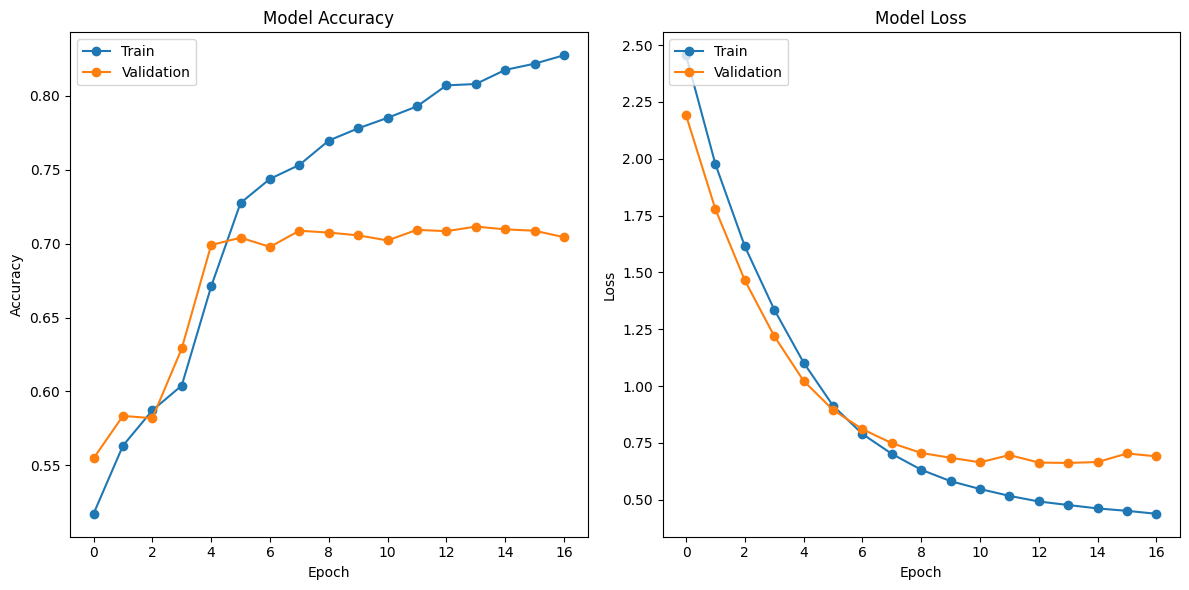

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Downloading necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Loading dataset
csv_path = "sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(csv_path, encoding='ISO-8859-1', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Defining sample size per category
sample_size_per_category = 10000  # 10000 positive and 10000 negative examples

# Sampling data ensuring a balanced distribution
df_sample_0 = df[df['polarity'] == 0].sample(sample_size_per_category, random_state=1)
df_sample_4 = df[df['polarity'] == 4].sample(sample_size_per_category, random_state=1)

# Combining the samples to create a balanced dataset
df_sample = pd.concat([df_sample_0, df_sample_4]).reset_index(drop=True)

# Verifying the sample distribution
print(df_sample['polarity'].value_counts())

# Function to preprocess text
def preprocess_text(text):
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Tokenizing the text
    text = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.lower() not in stop_words]
    # Applying stemming
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    # Applying lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

# Applying preprocessing to the text column with a progress bar
tqdm.pandas()
df_sample['processed_text'] = df_sample['text'].progress_apply(preprocess_text)


# Creating TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_sample['processed_text'])

# Spliting dataset into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, df_sample['polarity'], test_size=0.2, random_state=42, stratify=df_sample['polarity']
)

# Baseline Model: DummyClassifier
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_tfidf, y_train)

# Predicting and evaluating baseline model
baseline_predictions = baseline_model.predict(X_test_tfidf)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
print("Baseline Model Accuracy:", baseline_accuracy)
print("Baseline Classification Report:")
print(classification_report(y_test, baseline_predictions, zero_division=0))

# LSTM Approach:

# Tokenizing text for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_sample['processed_text'])
sequences = tokenizer.texts_to_sequences(df_sample['processed_text'])
X_lstm = pad_sequences(sequences, maxlen=100)

# Encoding labels
le = LabelEncoder()
y_lstm = le.fit_transform(df_sample['polarity'])

# Spliting dataset into training and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm
)

# Computing class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_lstm), y=y_lstm)
class_weights = dict(enumerate(class_weights))

# Defining the LSTM model
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=5000, output_dim=128)) 

# LSTM layer with regularization
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))

# Dropout for regularization
model.add(Dropout(0.5))

# Second LSTM layer
model.add(LSTM(64)) 

# Dropout for regularization
model.add(Dropout(0.5))  
model.add(Dense(1, activation='sigmoid')) 

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy']) 

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Training the model
history = model.fit(
    X_train_lstm, y_train_lstm, validation_split=0.2, epochs=30, callbacks=[early_stopping], 
    batch_size=64, verbose=1, class_weight=class_weights
)

# Evaluating the model
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f'LSTM Model Accuracy: {accuracy}')

# Classification report
y_pred_prob = model.predict(X_test_lstm)
# Converting probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype("int32")  
print(classification_report(y_test_lstm, y_pred, zero_division=0))

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


<h3>Unified Sentiment Scores for Text</h3>

In [21]:
def calculate_unified_sentiment_score_text(y_pred_prob_text, weights=None):
    num_classes = y_pred_prob_text.shape[1]
    
    # If there is only one class (binary classification), we skip weighting
    if num_classes == 1:
        return y_pred_prob_text.flatten()

    if weights is None:
        weights = np.ones(num_classes) / num_classes
    
    unified_sentiment_score_text = np.dot(y_pred_prob_text, weights)
    
    return unified_sentiment_score_text

# Make predictions on the test set
y_pred_prob = model.predict(X_test_lstm)

# Calculate the unified sentiment scores for text
unified_scores_text = calculate_unified_sentiment_score_text(y_pred_prob)

# Display the unified sentiment scores
print("Unified Sentiment Scores for Text:", unified_scores_text)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Unified Sentiment Scores for Text: [0.6993828  0.6390063  0.28529093 ... 0.8638967  0.9825865  0.6690353 ]


<h3>Image Data Collection and VGG16 + GRU Hybrid Model Implementation</h3>

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted successfully.
Baseline Model Accuracy: 0.13346336026748398
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.13      1.00      0.24       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.00      0.00      0.00      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.13      7178
   macro avg       0.02      0.14      0.03      7178
weighted avg       0.02      0.13      0.03      7178

Epoch 1/50


/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


649/649 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.2108 - loss: 8.3410 - val_accuracy: 0.3812 - val_loss: 4.8481 - learning_rate: 5.0000e-05
Epoch 2/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.3757 - loss: 4.2631 - val_accuracy: 0.4617 - val_loss: 2.8811 - learning_rate: 5.0000e-05
Epoch 3/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.4369 - loss: 2.7583 - val_accuracy: 0.4997 - val_loss: 2.1754 - learning_rate: 5.0000e-05
Epoch 4/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 49s 75ms/step - accuracy: 0.4606 - loss: 2.1852 - val_accuracy: 0.5014 - val_loss: 1.8999 - learning_rate: 5.0000e-05
Epoch 5/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 50s 76ms/step - accuracy: 0.4878 - loss: 1.8964 - val_accuracy: 0.5404 - val_loss: 1.6630 - learning_rate: 5.0000e-05
Epoch 6/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.5101 - loss: 1.7179 - val_accuracy: 0.5047 - val_loss: 1.6479 - learning_rate: 5.0000e-05
Epoch 7/50
649/649 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accurac

/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


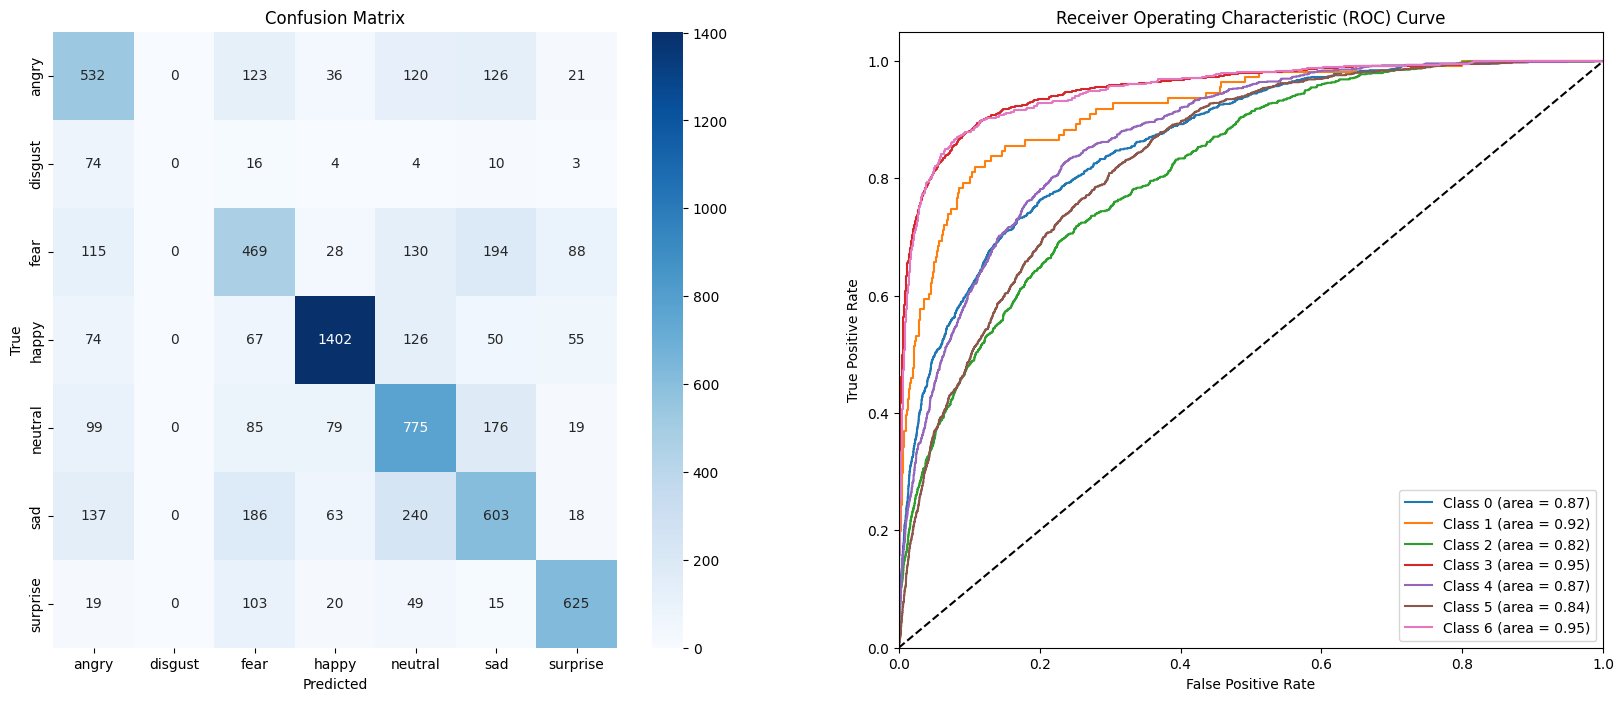

In [6]:
import os
import numpy as np
import cv2
import zipfile
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GRU, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Kaggle API credentials directory
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Download the FER-2013 dataset
!kaggle datasets download -d msambare/fer2013

# Unzip the downloaded dataset
with zipfile.ZipFile('fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')

print("Dataset downloaded and extracted successfully.")

# Loading and preprocessing images and labels
def load_images_and_labels(base_dir, num_samples=None):
    images = []
    labels = []
    label_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

    for label, idx in label_map.items():
        image_dir = os.path.join(base_dir, label)
        image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

        if num_samples:
            sample_size = min(num_samples // len(label_map), len(image_filenames))
            image_filenames = np.random.choice(image_filenames, sample_size, replace=False)
        
        for image_name in image_filenames:
            image_path = os.path.join(image_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Checking if the image is read correctly
            if image is not None:  
                image = cv2.resize(image, (48, 48))
                # Converting to RGB
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  
                image = image / 255.0
                images.append(image)
                labels.append(idx)
            else:
                print(f"Failed to read image: {image_path}")

    return np.array(images), np.array(labels)

# Loading training and validation data
train_dir = 'fer2013/train'
val_dir = 'fer2013/test'
X_train, y_train = load_images_and_labels(train_dir, num_samples=24000)
X_val, y_val = load_images_and_labels(val_dir)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

# Baseline Model: DummyClassifier
y_train_single = y_train.argmax(axis=1)
y_val_single = y_val.argmax(axis=1)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_flat, y_train_single)

baseline_predictions = baseline_model.predict(X_val_flat)
baseline_accuracy = accuracy_score(y_val_single, baseline_predictions)

print("Baseline Model Accuracy:", baseline_accuracy)
print("Baseline Classification Report:")
print(classification_report(y_val_single, baseline_predictions, zero_division=0))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Defining the VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Fine-tune VGG16 layers
for layer in vgg16_base.layers[:10]:
    layer.trainable = False
for layer in vgg16_base.layers[10:]:
    layer.trainable = True

# GRU Model
def create_vgg_gru_model(vgg16_base):
    model = Sequential([
        vgg16_base,
        TimeDistributed(Flatten()),
        BatchNormalization(),
        GRU(256, return_sequences=False, dropout=0.5, kernel_regularizer=l2(0.01)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

# compiling the model
hybrid_model_vgg_gru = create_vgg_gru_model(vgg16_base)
hybrid_model_vgg_gru.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with early stopping and learning rate reduction
hybrid_model_vgg_gru.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_val, y_val), 
    epochs=50, 
    callbacks=[early_stopping, reduce_lr]
)

# Evaluation function with ROC-AUC
def evaluate_model(model, X_val, y_val):
    label_map = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    y_pred = model.predict(X_val)
    y_true = y_val.argmax(axis=1)
    y_pred_classes = y_pred.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted')
    confusion = confusion_matrix(y_true, y_pred_classes)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print('Confusion Matrix:')
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Plot confusion matrix
    sns.heatmap(confusion, annot=True, fmt="d", cmap='Blues', xticklabels=label_map, yticklabels=label_map, ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('True')

    # Plot ROC curve for each class
    for i in range(7):
        fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        ax[1].plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[1].legend(loc="lower right")

    plt.show()

# Evaluating the hybrid VGG16 + GRU model
print("Evaluating VGG16 + GRU Hybrid Model")
evaluate_model(hybrid_model_vgg_gru, X_val, y_val)


<h3>Unified Sentiment Scores for Image</h3>

In [25]:
def calculate_unified_sentiment_score_image(y_pred_prob_image, weights=None):
    num_classes = y_pred_prob_image.shape[1]
    
    if weights is None:
        weights = np.ones(num_classes) / num_classes
    
    unified_sentiment_score_image = np.dot(y_pred_prob_image, weights)
    
    return unified_sentiment_score_image
    
# Making predictions on the validation set
y_pred_prob_image = hybrid_model_vgg_gru.predict(X_val)

# Calculating the unified sentiment scores for images
unified_scores_image = calculate_unified_sentiment_score_image(y_pred_prob_image)

# Display the first and last 3 scores 
unified_scores_image_display = np.concatenate([unified_scores_image[:3], unified_scores_image[-3:]])
print("Unified Sentiment Scores for Images:", unified_scores_image_display)


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Unified Sentiment Scores for Images: [0.14285714 0.14285714 0.14285713 0.14285713 0.14285715 0.14285714]


<h3>Audio Data Collection and CNN + Bidirectional GRU Model Implementation</h3>

/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset extracted successfully.
Extracted files: ['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']
Total audio files found: 1440


Processing audio files:  78%|██████████   | 1120/1440 [10:25<01:55,  2.77it/s]/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(
Processing audio files: 100%|█████████████| 1440/1440 [13:14<00:00,  1.81it/s]
/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sajanarora/miniforge3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

Total files processed: 4320
Dummy Classifier Accuracy: 11.81%
Classification Report for Dummy Classifier:
              precision    recall  f1-score   support

          01       0.00      0.00      0.00        63
          02       0.00      0.00      0.00       119
          03       0.00      0.00      0.00       121
          04       0.12      1.00      0.21       102
          05       0.00      0.00      0.00       116
          06       0.00      0.00      0.00       113
          07       0.00      0.00      0.00       115
          08       0.00      0.00      0.00       115

    accuracy                           0.12       864
   macro avg       0.01      0.12      0.03       864
weighted avg       0.01      0.12      0.02       864

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.1784 - loss: 4.5527 - val_accuracy: 0.2338 - val_loss: 3.0264 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.2208 - loss: 3.50

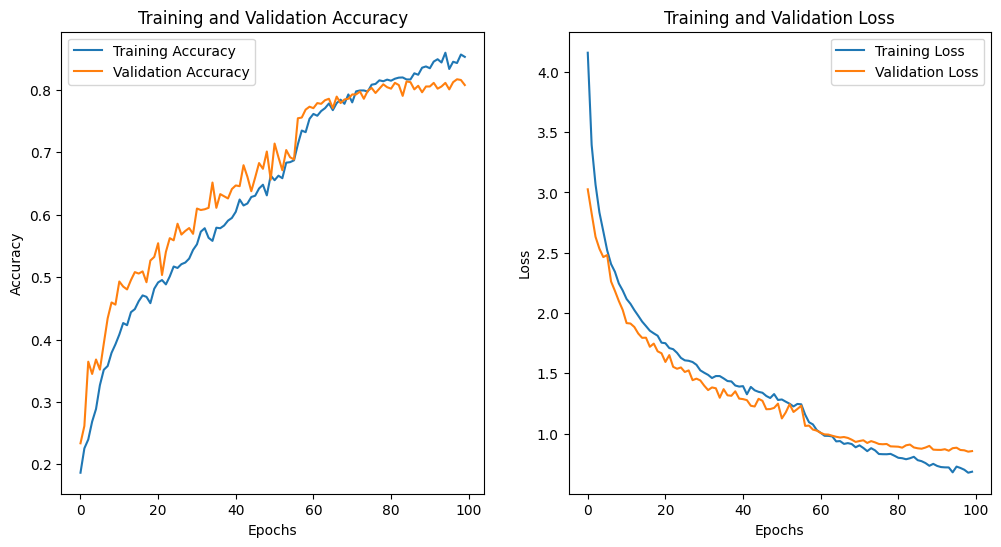

In [8]:
import os
import zipfile
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import noisereduce as nr
from keras.regularizers import l2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Extracting the Dataset
zip_path = "/Users/sajanarora/Desktop/PRO/archive (7).zip"
extract_path = "audio_speech_sentiment"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

# Data Preprocessing
def process_file(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        noise_clip = audio[:sample_rate]
        audio = nr.reduce_noise(y=audio, sr=sample_rate, y_noise=noise_clip)

        # Data augmentation
        audio_aug1 = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
        audio_aug2 = librosa.effects.time_stretch(audio, rate=0.8)

        # Feature extraction
        def extract_features(audio, sample_rate):
            n_fft = min(1024, len(audio))
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=n_fft)
            chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_fft=n_fft)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_fft=n_fft)
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)

            return np.concatenate([np.mean(mfccs.T, axis=0),
                                   np.mean(chroma.T, axis=0),
                                   np.mean(spectral_contrast.T, axis=0),
                                   np.mean(tonnetz.T, axis=0)])
        
        features = extract_features(audio, sample_rate)
        features_aug1 = extract_features(audio_aug1, sample_rate)
        features_aug2 = extract_features(audio_aug2, sample_rate)

        label = os.path.basename(file_path).split("-")[2]
        return [features, features_aug1, features_aug2], label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [None, None, None], None

def load_audio_files(file_path):
    features, labels = [], []

    audio_files = [os.path.join(dirpath, filename)
                   for dirpath, dirnames, filenames in os.walk(file_path)
                   for filename in filenames if filename.endswith(".wav")]

    print(f"Total audio files found: {len(audio_files)}")

    # Parallel processing for faster results
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, file) for file in audio_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing audio files"):
            feature_list, label = future.result()
            if all(f is not None for f in feature_list) and label is not None:
                features.extend(feature_list)
                labels.extend([label] * len(feature_list))

    print(f"Total files processed: {len(features)}")
    return np.array(features), np.array(labels)

features, labels = load_audio_files(extract_path)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Encode labels
le = LabelEncoder()
labels_encoded = to_categorical(le.fit_transform(labels))

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Baseline Model with Dummy Classifier
y_train_single = np.argmax(y_train, axis=1)
y_test_single = np.argmax(y_test, axis=1)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train_single)

y_pred_dummy = dummy_clf.predict(X_test)

dummy_accuracy = accuracy_score(y_test_single, y_pred_dummy)
print(f"Dummy Classifier Accuracy: {dummy_accuracy * 100:.2f}%")

print("Classification Report for Dummy Classifier:")
print(classification_report(y_test_single, y_pred_dummy, target_names=le.classes_))

# CNN + Bidirectional GRU Model Training
def create_cnn_bi_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(GRU(128, kernel_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

X_train_cnn_gru = X_train[..., np.newaxis]
X_test_cnn_gru = X_test[..., np.newaxis]

cnn_bi_gru_model = create_cnn_bi_gru_model((X_train_cnn_gru.shape[1], 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = cnn_bi_gru_model.fit(X_train_cnn_gru, y_train, epochs=100, batch_size=32,
                               validation_data=(X_test_cnn_gru, y_test),
                               callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Model Evaluation
cnn_bi_gru_score = cnn_bi_gru_model.evaluate(X_test_cnn_gru, y_test, verbose=0)
print(f"CNN + Bidirectional GRU Model Accuracy: {cnn_bi_gru_score[1]*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


<h3>Unified Sentiment Scores for Audio</h3>

In [23]:
def calculate_unified_sentiment_score_audio(y_pred_prob_audio, weights=None):
    num_classes = y_pred_prob_audio.shape[1]
    
    if weights is None:
        weights = np.ones(num_classes) / num_classes
    
    unified_sentiment_score_audio = np.dot(y_pred_prob_audio, weights)
    
    return unified_sentiment_score_audio

# Making predictions on the test set
y_pred_prob_audio = cnn_bi_gru_model.predict(X_test_cnn_gru)

# Calculating the unified sentiment scores for audio
unified_scores_audio = calculate_unified_sentiment_score_audio(y_pred_prob_audio)

# Display the first and last 3 scores 
unified_scores_audio_display = np.concatenate([unified_scores_audio[:3], unified_scores_audio[-3:]])
print("Unified Sentiment Scores for Audio:", unified_scores_audio_display)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Unified Sentiment Scores for Audio: [0.12500001 0.125      0.12500001 0.125      0.125      0.12499999]


<h3>Comparison of Unified Sentiment Scores</h3>

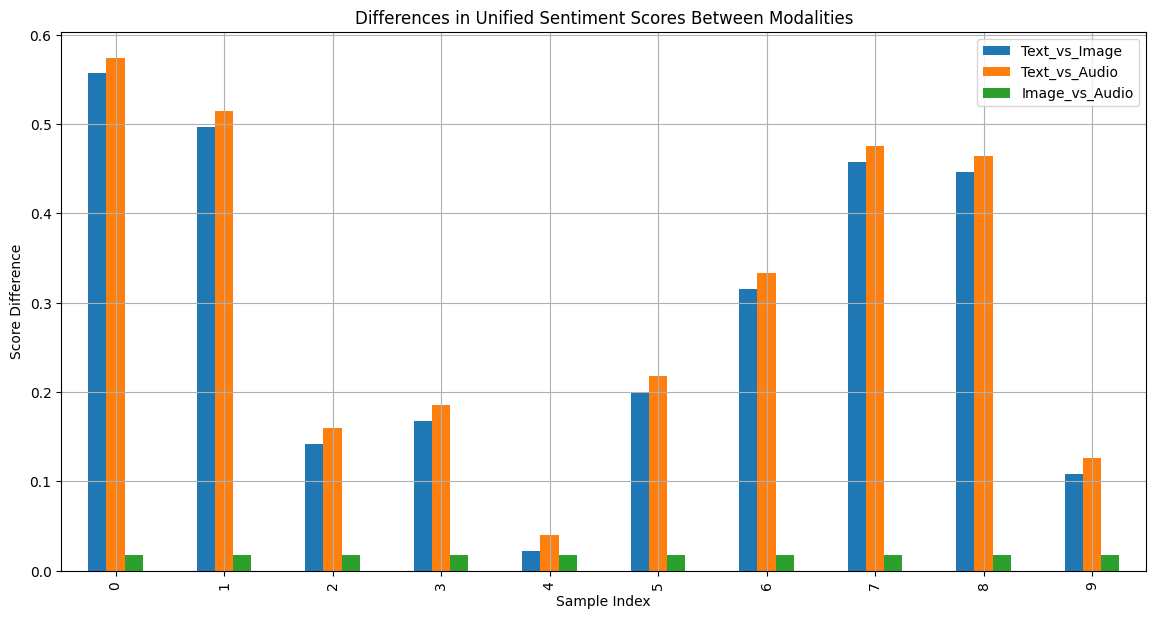

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensuring all unified score arrays are truncated to the minimum length
min_length = min(len(unified_scores_text), len(unified_scores_image), len(unified_scores_audio))
unified_scores_text = unified_scores_text[:min_length]
unified_scores_image = unified_scores_image[:min_length]
unified_scores_audio = unified_scores_audio[:min_length]

# Creating a DataFrame to compare the scores
comparison_df = pd.DataFrame({
    'Text_Score': unified_scores_text,
    'Image_Score': unified_scores_image,
    'Audio_Score': unified_scores_audio
})

# Calculating the differences between the modalities
comparison_df['Text_vs_Image'] = comparison_df['Text_Score'] - comparison_df['Image_Score']
comparison_df['Text_vs_Audio'] = comparison_df['Text_Score'] - comparison_df['Audio_Score']
comparison_df['Image_vs_Audio'] = comparison_df['Image_Score'] - comparison_df['Audio_Score']

# Plot the differences between the modalities
comparison_df[['Text_vs_Image', 'Text_vs_Audio', 'Image_vs_Audio']].head(10).plot(kind='bar', figsize=(14, 7))
plt.title('Differences in Unified Sentiment Scores Between Modalities')
plt.xlabel('Sample Index')
plt.ylabel('Score Difference')
plt.grid(True)
plt.show()
